In [1]:
import pandas as pd
import numpy as np
import psycopg2
from sklearn.metrics import mean_absolute_error, mean_squared_error
# from scipy.optimize import minimize
from scipy.optimize import minimize_scalar, minimize
pd.set_option('mode.chained_assignment', None)
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable

As we passed the NHL season's first quarter mark, I propose an evaluation of every team, using a staple of sports analytics: the Pythagorean Expectation. The formula, orignally outlined by baseball analyst, relates runs scored and conceded by a team with its win percentage. I start by adapting the formula to NHL scores using the mean absolute error criterion, and use it to evaluate how teams performed against expectations.

In [2]:
conn = psycopg2.connect("dbname=nhl_db")
cur = conn.cursor()

In [3]:
cur.execute("""
    SELECT
        team,
        season,
        game_date,
        win,
        loss,
        ot_loss,
        goals_for,
        goals_against
    FROM summary
    WHERE playoffs = FALSE
    AND season >= '2012/13'
""")

In [4]:
df = pd.DataFrame(data=cur.fetchall(), columns=["team", "season", "date", "wins", "losses", "ot_losses", "goals_for", "goals_against"])

In [5]:
conn.close()

In [6]:
df.wins = df.wins + (0.5 * df.ot_losses)
df.drop("ot_losses", axis=1, inplace=True)
df["games_played"] = 1

In [7]:
season_df = df.groupby(["team", "season"], as_index=False).sum(numeric_only=True)

In [8]:
season_df["win_pc"] = season_df["wins"] / season_df["games_played"]

In [9]:
new_season_df = season_df.loc[season_df.season == "2022/23", :]
season_df = season_df.loc[season_df.season != "2022/23", :]

In [10]:
def pythagoreanExpectation(row, alpha=2):
    return row.games_played * pow(row.goals_for,alpha) / (pow(row.goals_for,alpha) + pow(row.goals_against,alpha))

In [17]:
def optimizePythagoreanExpectation(df, column_name):
    def f(alpha):
        expected_pc = pow(df["goals_for"], alpha) / ((pow(df["goals_for"], alpha)) + (pow(df["goals_against"], alpha)))
        err = ((df["win_pc"] - expected_pc).abs() * df["games_played"]).sum()

        return err

    res = minimize(f, x0=2.0)
    print(res.x)
    df[f"{column_name}_alpha"] = res.x[0]
    df[f"{column_name}_exp_pc"] = pow(df["goals_for"], res.x[0]) / (pow(df["goals_for"], res.x[0]) + pow(df["goals_against"], res.x[0]))
    df[f"{column_name}_exp_wins"] = df["games_played"] * df[f"{column_name}_exp_pc"]
    df[f"{column_name}_mae"] = res.fun / df["games_played"].sum()
    df[f"{column_name}_mae_per_82"] = 82 * df[f"{column_name}_mae"]
    
    return df

In [18]:
# cut_offs = ["2012/13", "2017/18", "2019/20", "2021/22"]
cut_offs = ["2007/08"]

In [19]:
for season in season_df.season.unique():
    alpha_df = optimizePythagoreanExpectation(
        season_df.loc[season_df.season >= season, :],
        f"{season}")
    alpha_df[["season", "team", f"{season}_alpha", f"{season}_exp_pc", f"{season}_exp_wins", f"{season}_mae", f"{season}_mae_per_82",]]
    
    season_df = season_df.merge(alpha_df, how="left")

[2.21744502]
[2.21744502]
[2.24552455]
[2.13994643]
[2.13994644]
[2.13994643]
[2.13994643]
[2.13994644]
[2.13994644]
[2.13994644]


In [20]:
season_df.tail()

,team,season,wins,losses,goals_for,goals_against,games_played,win_pc,2012/13_alpha,2012/13_exp_pc,...,2020/21_alpha,2020/21_exp_pc,2020/21_exp_wins,2020/21_mae,2020/21_mae_per_82,2021/22_alpha,2021/22_exp_pc,2021/22_exp_wins,2021/22_mae,2021/22_mae_per_82
301,WSH,2017/18,52.5,26,256,238,82,0.640244,2.217445,0.540329,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
302,WSH,2018/19,52.0,26,274,248,82,0.634146,2.217445,0.555045,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
303,WSH,2019/20,45.0,20,236,212,69,0.652174,2.217445,0.559174,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
304,WSH,2020/21,38.5,15,188,161,56,0.687500,2.217445,0.585110,...,2.139946,0.582191,32.602668,0.05637,4.622315,NaN,NaN,NaN,NaN,NaN
305,WSH,2021/22,50.0,26,270,242,82,0.609756,2.217445,0.560397,...,2.139946,0.558306,45.781103,0.05637,4.622315,2.139946,0.558306,45.781103,0.055415,4.544058


In [ ]:
# ["optimal coefficient"] + [round(season_df[f"{season}_alpha"].max(),5) for season in cut_offs]

In [ ]:
# x = PrettyTable()
# x.field_names = ["", "last 10 seasons", "last 5 seasons", "last 3 seasons", "last season"]
# x.add_rows([
#     ["optimal coefficient"] + [round(season_df[f"{season}_alpha"].max(),5) for season in cut_offs],
#     ["", "", "", "", ""],
#     ["optimal mean absolute error"] + [round(season_df[f"{season}_mae"].max(),5) for season in cut_offs],
# ])
# print(x)

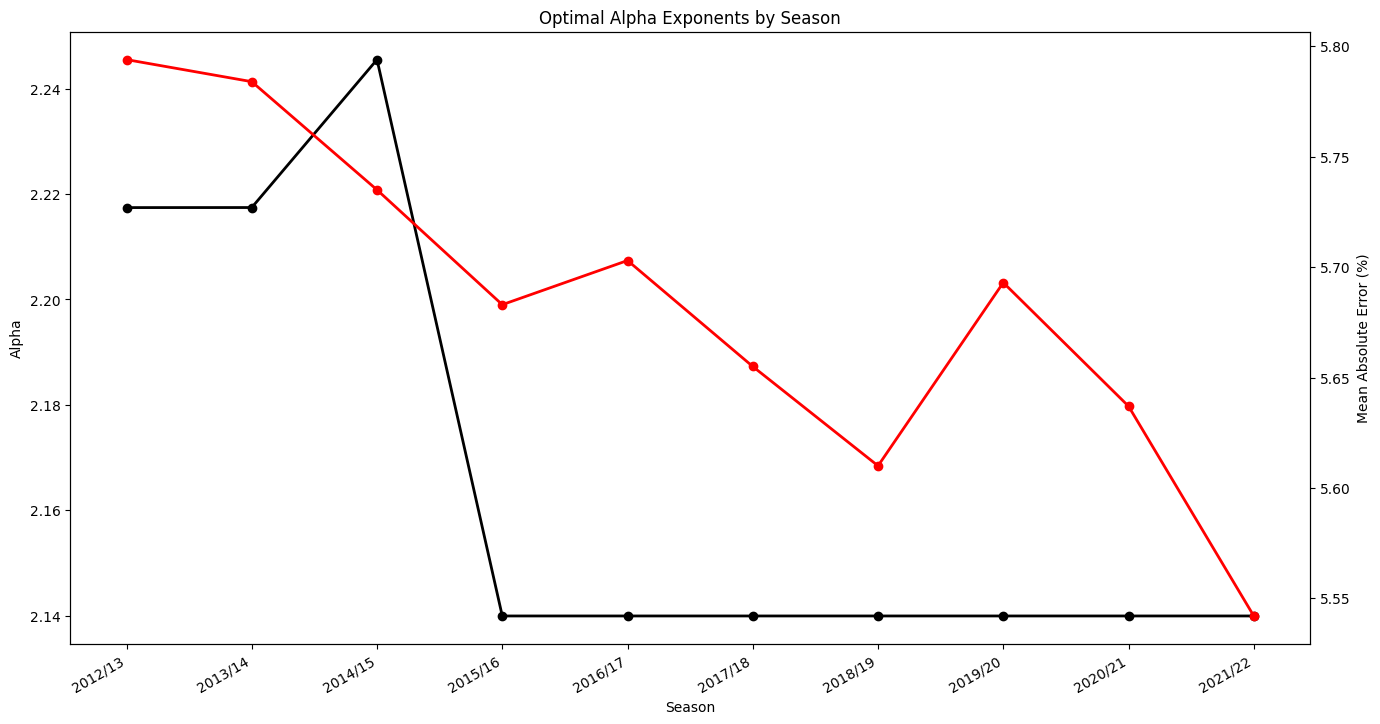

In [21]:
fig, ax = plt.subplots(figsize=(16,9))

ax.set_title("Optimal Alpha Exponents by Season")
ax.set_xlabel("Season")
ax.set_ylabel("Alpha")

ax2=ax.twinx()
ax2.set_ylabel("Mean Absolute Error (%)")
fig.autofmt_xdate()

xs = season_df["season"].unique()
y1s = [round(season_df[f"{season}_alpha"].max(),5) for season in xs]
y2s = [100 * round(season_df[f"{season}_mae"].max(), 5) for season in xs]

ax.plot(xs, y1s, 'o-', linewidth=2.0, color="black")
ax2.plot(xs, y2s, 'o-', linewidth=2.0, color="red")


plt.show()

In [ ]:
pow(season_df.goals_for,1.7)